In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() do Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [3]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


VARIABLE DESCRIPTIONS
Survived - Survival (0 = No; 1 = Yes);
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
Name - Name;
Sex - Sex;
Age - Age;
SibSp - Number of Siblings/Spouses Aboard;
Parch - Number of Parents/Children Aboard;
Ticket - Ticket Number;
Fare - Passenger Fare (British pound);
Cabin - Cabin;
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

# Lidando com missing values
Removendo missing values
Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.

In [4]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

# Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

In [5]:
dict_box = {}
for _, df in titanic_data.groupby(['Pclass','Sex']):
    Pclass = df.Pclass.values[0]
    Sex = df.Sex.values[0]
    Ages = df.Age.values
    dict_box.update({'{}_{}'.format(Pclass,Sex):Ages})

df_box = pd.DataFrame.from_dict(dict_box, orient='index').T

Com esse diagrama podemos ver que existe alguma relação entre a idade do passageiro, a classe que ele ocupa e seu sexo. Por exemplo podemos afirmar que em média os passageiros da primeira classe são mais velhos que os das demais classes. Também podemos dizer que no geral a idade dos passageiros do sexo masculino é maior que os passageros do sexo feminino.

Podemos então criar uma regra para preencher as lacunas nas idades. A regra será: preencher as lacunas com a mediana de cada grupo do diagrama acima. Desta forma vamos preencher os valores faltantes de uma maneira um pouco mais acertiva.

Vamos dar uma olhada para saber que valores seriam estes exatamente.

In [6]:
titanic_data['Age'].fillna(titanic_data.groupby(['Pclass','Sex'])['Age'].transform('median'),inplace=True)
titanic_data['Embarked'].fillna('S',inplace=True)

In [7]:
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Não temos mais valores nulos. Podemos prosseguir

# Converting categorical variables to a dummy indicators

In [8]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=False)
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=False)
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)

titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,female,male,C,Q,S
0,0,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,0,0,1


In [9]:
X = titanic_dmy.iloc[:,1:].values
y = titanic_dmy.iloc[:,0].values

Agora dividir em treino e teste (teste com 30%)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# APLICANDO O PIPELINE DE PREDIÇÃO NOS DADOS TRATADOS

In [11]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

my_pipeline = Pipeline(steps=[
    ('model', SVC(random_state=0, kernel='linear'))
])

my_pipeline.fit(X_train, y_train)
y_pred = my_pipeline.predict(X_test)

Average MAE score (across experiments):
0.21211464591746285


# Avaliando o modelo
analisando o rotulo real com o rotulo estimado.

<AxesSubplot:>

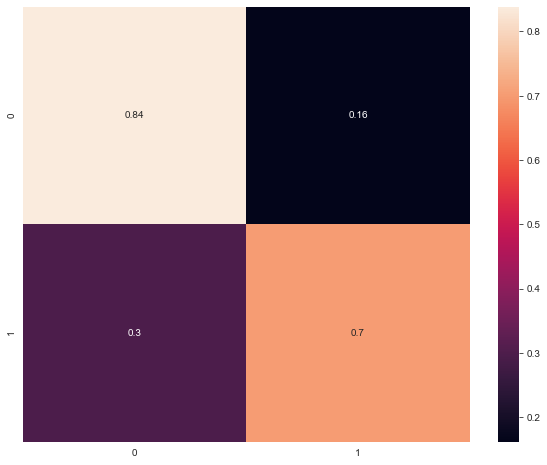

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred, normalize='true')


sns.heatmap(confusion_matrix, annot=True)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



# Buscando os melhores parametros com GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

my_pipeline = Pipeline(steps=[
    ('model', SVC(random_state=0))
])

param_grid = {
    'model__kernel': ['linear', 'rbf']
}

search = GridSearchCV(my_pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

y_pred = search.predict(X_test)

<AxesSubplot:>

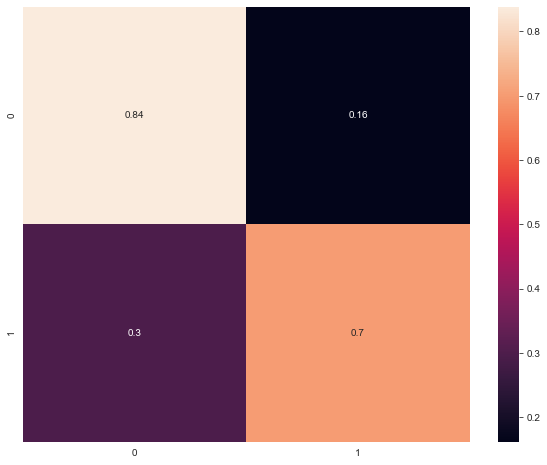

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred, normalize='true')


sns.heatmap(confusion_matrix, annot=True)

# Trocando de SVM para Random Forest Classifier

A ideia aqui é usar o grid search para buscar os melhores parametros, como eu coloquei uma lista maior de parametros pode demorar um pouco pra rodar, eu deixei 2 parametros de busca, o heavy é consideravelmente mais demorado do que o light, vai exigir muito menos processador

In [28]:
from sklearn.ensemble import RandomForestClassifier

my_pipeline = Pipeline(steps=[
    ('model', RandomForestClassifier(random_state=0))
])

param_grid_heavy = {
    'model__criterion': ['gini', 'entropy'],
    'model__n_estimators': [10, 100, 1000, 10000],
    'model__min_samples_split': [2, 3, 4, 8],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_light = {
    'model__criterion': ['gini', 'entropy'],
    'model__n_estimators': [10, 100],
    'model__min_samples_split': [2, 8],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['auto', 'log2']
}

search = GridSearchCV(my_pipeline, param_grid_heavy, n_jobs=-1)
search.fit(X_train, y_train)

y_pred = search.predict(X_test)

<AxesSubplot:>

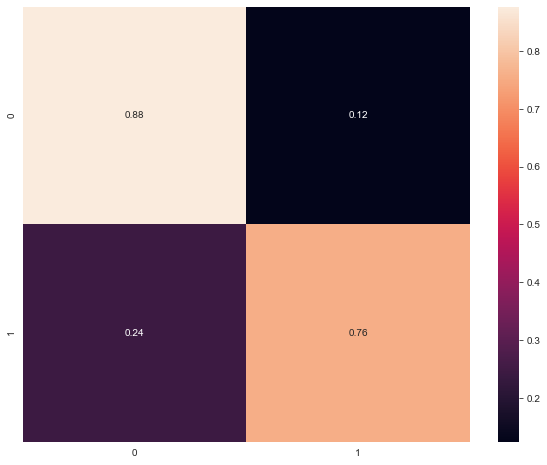

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred, normalize='true')

sns.heatmap(confusion_matrix, annot=True)